<a href="https://colab.research.google.com/github/PaulToronto/Stanford-Andrew-Ng-Machine-Learning-Specialization/blob/main/1_3_3_1_Lab_Gradient_descent_for_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab - Gradient descent for logistic regression

## Imports

In [1]:
import pandas as pd
import numpy as np
import copy, math

import matplotlib.pyplot as plt

## Toy Dataset

In [2]:
data = pd.DataFrame({
    'x1': [0.5, 1, 1.5, 3, 2, 1],
    'x2': [1.5, 1, 0.5, 0.5, 2, 2.5],
    'y': [0, 0, 0, 1, 1, 1]
})

data

,x1,x2,y
0,0.5,1.5,0
1,1.0,1.0,0
2,1.5,0.5,0
3,3.0,0.5,1
4,2.0,2.0,1
5,1.0,2.5,1


In [3]:
x_train = data.drop('y', axis=1).values
y_train = data['y'].values
x_train, y_train

(array([[0.5, 1.5],
        [1. , 1. ],
        [1.5, 0.5],
        [3. , 0.5],
        [2. , 2. ],
        [1. , 2.5]]),
 array([0, 0, 0, 1, 1, 1]))

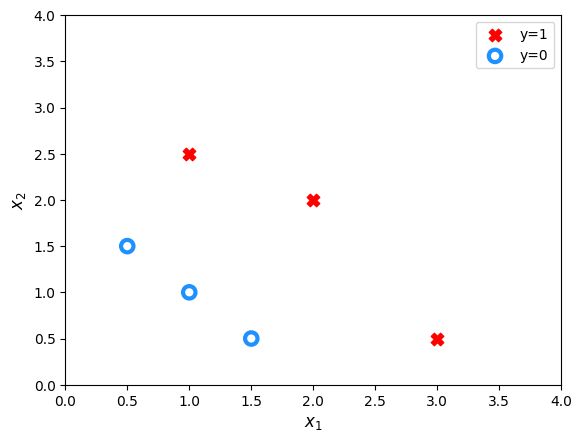

In [4]:
pos = (y_train == 1)
neg = (y_train == 0)

plt.scatter(x_train[pos, 0], x_train[pos, 1],
              marker='X', s=80, c='red', label='y=1')
plt.scatter(x_train[neg, 0], x_train[neg, 1],
              marker='o', s=80, facecolors='none',
              edgecolor='dodgerblue', lw=3, label='y=0')
plt.axis([0, 4, 0, 4])
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.legend()

plt.show()

## Logistic Gradient Descent

### Sigmoid

The sigmoid function (aka logistic function) only has outputs between 0 and 1.

$$
g(z) = \frac{1}{1 + e^{-z}}
$$
<br>
$$
0 \lt g(z) \lt 1
$$

In [5]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Parameters
    ----------
    z : array_like
        A scalar or numpy array of any size.

    Returns
    -------
     g : array_like
         sigmoid(z)
    """
    z = np.clip( z, -500, 500 )           # protect against overflow
    g = 1.0/(1.0+np.exp(-z))

    return g

### Prediction

$$
f_{\vec{w},b}\left(\vec{x}\right) = \frac{1}{1 + e^{-(\vec{w}\cdot\vec{x} + b)}}
$$

$$
P(y = 1|\vec{x};\vec{w},b)
$$

In [6]:
def predict_logistic(X, w, b):
    """ performs prediction """
    return sigmoid(X @ w + b)

### Cost Function

$$
J\left(\vec{w},b\right) = -\frac{1}{m}\sum_{i=1}^{m}\left(y^{(i)}\log{\left(f_{\vec{w},b}\left(\vec{x}^{(i)}\right)\right)} + \left(1 - y^{(i)}\right)\log{\left(1 - f_{\vec{w},b}\left(\vec{x}^{(i)}\right)\right)}\right)
$$

In [7]:
def compute_cost_logistic(X, y, w, b):
    """
    Computes cost using logistic loss, non-matrix version

    Args:
      X (ndarray): Shape (m,n)  matrix of examples with n features
      y (ndarray): Shape (m,)   target values
      w (ndarray): Shape (n,)   parameters for prediction
      b (scalar):               parameter  for prediction
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]

    cost = 0.0
    for i in range(m):
        z_i = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z_i)
        cost += y[i] * np.log(f_wb_i) + (1 - y[i]) * np.log(1 - f_wb_i)

    cost = -(cost / m)

    return cost

### Gradient

$$
\begin{align}
\frac{\partial}{\partial w_j} &= \frac{1}{m}\sum_{i=1}^{m}\left(f_{\vec{w},b}\left(\vec{x}^{(i)}\right) - y^{(i)}\right)x_j^{(i)} \\
\frac{\partial}{\partial b} &= \frac{1}{m}\sum_{i=1}^{m}\left(f_{\vec{w},b}\left(\vec{x}^{(i)}\right) - y^{(i)}\right)
\end{align}
$$

In [8]:
def compute_gradient_logistic(X, y, w, b):
    """
    Computes the gradient for linear regression

    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters
      b (scalar)      : model parameter
    Returns
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w.
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b.
    """
    m, n = X.shape
    dj_dw = np.zeros((n,))
    dj_db = 0.0

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i], w) + b)
        err_i = f_wb_i - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]
        dj_db = dj_db + err_i

    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_db, dj_dw

dj_db, dj_dw = compute_gradient_logistic(x_train, y_train, np.array([2.0, 3.0]), 1.0)

dj_db, dj_dw

(0.49861806546328574, array([0.49833339, 0.49883943]))

### Gradient Descent

repeat {
$$
\begin{align}
w_j &= w_j - \alpha \frac{\partial}{\partial w_j}J\left(\vec{w}, b\right) \\
b &= b - \alpha \frac{\partial}{\partial b}J\left(\vec{w}, b\right)
\end{align}
$$
}

In [9]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters):
    """
    Performs batch gradient descent

    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      num_iters (scalar) : number of iterations to run gradient descent

    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter
      J_history (List)   : History of cost values
    """

    J_history = [] # an array of cost values
    w = copy.deepcopy(w_in) # avoid modifying global w within the function
    b = b_in

    for i in range(num_iters):
        # calculate the gradient
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)

        # update the parameters
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # save cost at each iteration
        if i < 100_000: # prevent resource exhaustion
            J_history.append(compute_cost_logistic(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % math.ceil(num_iters / 10) == 0:
            print(f'Iteration {i:4d}: Cost {J_history[-1]}')

    return w, b, J_history

w_out, b_out, j_hist = gradient_descent(x_train,
                                        y_train,
                                        w_in = np.zeros_like(x_train[0]),
                                        b_in = 0.0,
                                        alpha=0.1,
                                        num_iters=10_000)

Iteration    0: Cost 0.684610468560574
Iteration 1000: Cost 0.1590977666870457
Iteration 2000: Cost 0.08460064176930078
Iteration 3000: Cost 0.05705327279402531
Iteration 4000: Cost 0.04290759421682
Iteration 5000: Cost 0.03433847729884557
Iteration 6000: Cost 0.02860379802212006
Iteration 7000: Cost 0.02450156960879306
Iteration 8000: Cost 0.02142370332569295
Iteration 9000: Cost 0.019030137124109114


In [10]:
w_out, b_out

(array([5.28123029, 5.07815608]), -14.222409982019837)

### Plot the results of gradient descent